# [FinRL: 强化学习在量化金融中的应用](https://github.com/QYQSDTC/FinRL)
*注：本文不构成任何投资建议，入市有风险，投资需谨慎。*
## 小组成员
钱以骞 物理学院 D202180035

马瑞廷 计算机学院

张文涛 计算机学院

丛宇恒 计算机学院

## 目标
- 了解强化学习在量化金融中的应用
- 通过强化学习的方法，实现一个简单的量化交易策略
- 比较不同的强化学习算法在量化金融中的表现
  - 钱以骞：DDPG
  - 张文涛：SAC
  - 丛宇恒：A2C
  - 马瑞妍：PPO

## 用到的Package
- [FinRL](https://github.com/AI4Finance-Foundation/FinRL): 一个强化学习在量化金融中的应用的开源库
- [Tushare](https://tushare.pro/): 一个免费的金融数据接口
- [Quantopian Pyfolio](https://github.com/quantopian/pyfolio): 一个自动化回测工具包

### Import modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_rows', 100, 'display.min_rows', 50,'display.max_columns', 100)
from IPython import display
import tushare as ts
display.set_matplotlib_formats("svg")

from meta import config
from meta.data_processors.tushare import Tushare, ReturnPlotter
from meta.env_stock_trading.env_stocktrading_China_A_shares import StockTradingEnv
from agents.stablebaselines3_models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import datetime
    
print("ALL Modules have been imported!")

ALL Modules have been imported!


## Create folders

In [2]:
import os
if not os.path.exists("./datasets" ):
    os.makedirs("./datasets" )
if not os.path.exists("./trained_models"):
    os.makedirs("./trained_models" )
if not os.path.exists("./tensorboard_log"):
    os.makedirs("./tensorboard_log" )
if not os.path.exists("./results" ):
    os.makedirs("./results" )

## Data preparation: download, cleansing and feature engineering
我们用Tushare获取了A股市场近10年的数据 (2012/01/01 -- 2022/09/28)，包括开盘价、收盘价、最高价、最低价、成交量、成交额、涨跌幅等信息。我们用这些数据来训练我们的强化学习模型。
### 个股的选择
因为本项目的主要目的是研究强化学习在量化金融中的应用，所以个股的选择我们就简单的从上证50中选取了5只权重股，包括：贵州茅台，万华化学，中国平安，中国中免，恒瑞医药。

如果想要更好的收益，可以用量化因子选股或者其它的一些量化方法，但是这不在本项目的讨论范围内。

In [3]:
train_start_date='2012-01-01'
train_stop_date='2020-01-01'
trade_start_date='2020-01-01'
trade_stop_date='2022-09-30'

# token='27080ec403c0218f96f388bca1b1d85329d563c91a43672239619ef5'
token='829a1fbce8eb0e34f05ab19906d0e08227c6f64261a81272aa078ccd'

pro = ts.pro_api(token)

In [4]:
pro.index_weight(index_code = '000016.SH', start_date = '20220901')

,index_code,con_code,trade_date,weight
0,000016.SH,601012.SH,20220930,4.460
1,000016.SH,600745.SH,20220930,0.547
2,000016.SH,600104.SH,20220930,1.026
3,000016.SH,600690.SH,20220930,1.440
4,000016.SH,601088.SH,20220930,1.602
5,000016.SH,600028.SH,20220930,0.881
6,000016.SH,600809.SH,20220930,2.270
7,000016.SH,601995.SH,20220930,0.309
8,000016.SH,600519.SH,20220930,18.058
9,000016.SH,601919.SH,20220930,1.071


In [5]:
# ticket_list=['600519.SH', '600309.SH', '601318.SH', '601888.SH', '600276.SH']
# take 上证50成分股
ticker_list = pro.index_weight(index_code = '000016.SH', start_date = '20220901').con_code.unique().tolist()
ticker_list
print(f'Number of stocks: {len(ticker_list)}, stocks: {ticker_list}')

Number of stocks: 50, stocks: ['601012.SH', '600745.SH', '600104.SH', '600690.SH', '601088.SH', '600028.SH', '600809.SH', '601995.SH', '600519.SH', '601919.SH', '601166.SH', '601668.SH', '601601.SH', '600436.SH', '601066.SH', '601318.SH', '600030.SH', '600588.SH', '600276.SH', '600438.SH', '600570.SH', '603501.SH', '600837.SH', '603288.SH', '603986.SH', '601688.SH', '600036.SH', '601857.SH', '600196.SH', '603799.SH', '600887.SH', '600111.SH', '600031.SH', '600048.SH', '600905.SH', '601398.SH', '601633.SH', '601288.SH', '600893.SH', '601628.SH', '600010.SH', '600585.SH', '600900.SH', '603259.SH', '601899.SH', '601888.SH', '600346.SH', '601728.SH', '601211.SH', '600309.SH']


In [6]:
# download and clean
ts_processor = Tushare(data_source="tushare", 
                                   start_date=train_start_date,
                                   end_date=trade_stop_date,
                                   time_interval="1d",
                                   token=token)

In [7]:
ts_processor.download_data(ticker_list=ticker_list)
ts_processor.dataframe.to_csv('./datasets/A_stock.csv')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


Shape of DataFrame:  (113660, 8)


In [8]:
df = pd.read_csv('./datasets/A_stock.csv')
len(df.tic.unique())

50

### Clean Data

In [9]:
df = df.sort_values(["date", "tic"], ignore_index=True)
df.index = df.date.factorize()[0]
merged_closes = df.pivot_table(index="date", columns="tic", values="close")
merged_closes

tic,600010.SH,600028.SH,600030.SH,600031.SH,600036.SH,600048.SH,600104.SH,600111.SH,600196.SH,600276.SH,600309.SH,600346.SH,600436.SH,600438.SH,600519.SH,600570.SH,600585.SH,600588.SH,600690.SH,600745.SH,600809.SH,600837.SH,600887.SH,600893.SH,600900.SH,600905.SH,601012.SH,601066.SH,601088.SH,601166.SH,601211.SH,601288.SH,601318.SH,601398.SH,601601.SH,601628.SH,601633.SH,601668.SH,601688.SH,601728.SH,601857.SH,601888.SH,601899.SH,601919.SH,601995.SH,603259.SH,603288.SH,603501.SH,603799.SH,603986.SH
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-04,4.15,7.36,9.56,12.09,11.67,10.05,14.16,37.61,8.34,28.45,12.50,7.07,73.03,4.85,185.27,11.50,15.28,16.90,8.78,5.79,57.79,7.12,19.73,13.29,6.29,NaN,NaN,NaN,24.60,12.50,NaN,2.60,33.90,4.22,19.04,17.46,11.87,2.86,7.62,NaN,9.75,25.59,3.81,4.50,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,4.10,7.42,9.29,12.06,11.91,9.80,14.39,35.64,8.25,27.00,12.10,6.86,70.50,4.66,183.15,10.70,14.92,16.48,8.73,5.54,55.04,7.08,19.33,12.66,6.24,NaN,NaN,NaN,24.29,12.71,NaN,2.65,33.93,4.25,19.12,16.58,12.10,2.87,7.36,NaN,9.80,24.17,3.78,4.30,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,4.34,7.48,9.39,12.06,11.99,9.71,14.20,36.32,8.08,26.55,12.06,6.40,70.08,4.72,186.64,10.67,14.72,16.23,8.79,5.76,53.69,7.30,19.66,12.95,6.22,NaN,NaN,NaN,24.27,12.79,NaN,2.66,33.85,4.28,19.23,16.73,11.81,2.87,7.49,NaN,9.96,23.61,3.80,4.32,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,4.48,7.75,9.75,12.55,12.38,10.17,14.90,39.02,8.34,27.40,12.47,6.64,70.10,4.89,188.01,11.00,15.55,16.58,9.07,6.00,54.59,7.62,20.13,13.39,6.29,NaN,NaN,NaN,26.01,13.04,NaN,2.68,34.73,4.31,19.73,17.28,12.26,2.93,7.79,NaN,10.03,24.41,3.93,4.47,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-10,4.54,7.79,10.12,13.31,12.56,10.35,15.25,40.39,8.66,27.75,13.21,7.02,72.00,5.10,194.48,11.34,16.59,17.02,9.42,6.21,57.00,7.93,20.58,13.79,6.40,NaN,NaN,NaN,26.76,13.15,NaN,2.69,36.29,4.35,20.40,18.23,12.46,3.08,8.13,NaN,10.12,25.60,4.12,4.68,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-11,4.79,7.70,10.08,13.13,12.49,10.31,15.10,42.63,8.63,27.70,13.25,7.14,72.85,5.06,189.68,11.25,16.38,17.79,9.26,6.13,57.67,7.85,20.61,13.72,6.38,NaN,NaN,NaN,26.49,13.02,NaN,2.67,35.83,4.35,20.20,18.22,12.41,3.04,8.00,NaN,10.04,25.95,4.16,4.63,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-12,4.77,7.66,10.03,13.22,12.62,10.39,15.29,43.46,8.58,27.37,13.31,7.07,73.99,5.03,190.35,11.05,16.51,17.14,9.23,6.28,55.89,7.85,20.50,14.10,6.41,NaN,NaN,NaN,26.49,13.30,NaN,2.65,36.37,4.33,20.03,18.30,12.65,3.04,7.93,NaN,10.06,25.47,4.15,4.69,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-13,4.69,7.62,9.80,12.92,12.49,10.28,14.69,44.96,8.31,26.80,12.83,6.81,71.73,4.87,188.69,10.49,15.75,16.51,8.83,6.50,53.98,7.71,20.22,13.26,6.35,NaN,NaN,NaN,26.33,13.28,NaN,2.65,36.03,4.34,19.95,17.89,12.26,3.01,7.87,NaN,10.20,24.93,4.06,4.48,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-16,4.32,7.54,9.83,13.06,12.39,9.93,14.39,41.08,8.17,26.00,12.50,6.52,69.15,4.76,177.41,10.30,15.28,16.03,8.70,5.91,50.77,7.64,19.01,12.89,6.36,NaN,NaN,NaN,26.02,13.32,NaN,NaN,35.59,4.31,19.85,17.81,NaN,2.98,7.73,NaN,10.09,23.59,3.96,4.38,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data_length = len(merged_closes)
merged_closes.dropna(axis=1, thresh = int(0.9*data_length), inplace=True)
merged_closes

tic,600010.SH,600028.SH,600030.SH,600031.SH,600036.SH,600048.SH,600104.SH,600111.SH,600196.SH,600276.SH,600309.SH,600436.SH,600438.SH,600519.SH,600570.SH,600585.SH,600588.SH,600690.SH,600809.SH,600837.SH,600887.SH,600893.SH,600900.SH,601012.SH,601088.SH,601166.SH,601288.SH,601318.SH,601398.SH,601601.SH,601628.SH,601633.SH,601668.SH,601688.SH,601857.SH,601888.SH,601899.SH,601919.SH
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-04,4.15,7.36,9.56,12.09,11.67,10.05,14.16,37.61,8.34,28.45,12.50,73.03,4.85,185.27,11.50,15.28,16.90,8.78,57.79,7.12,19.73,13.29,6.29,NaN,24.60,12.50,2.60,33.90,4.22,19.04,17.46,11.87,2.86,7.62,9.75,25.59,3.81,4.50
2012-01-05,4.10,7.42,9.29,12.06,11.91,9.80,14.39,35.64,8.25,27.00,12.10,70.50,4.66,183.15,10.70,14.92,16.48,8.73,55.04,7.08,19.33,12.66,6.24,NaN,24.29,12.71,2.65,33.93,4.25,19.12,16.58,12.10,2.87,7.36,9.80,24.17,3.78,4.30
2012-01-06,4.34,7.48,9.39,12.06,11.99,9.71,14.20,36.32,8.08,26.55,12.06,70.08,4.72,186.64,10.67,14.72,16.23,8.79,53.69,7.30,19.66,12.95,6.22,NaN,24.27,12.79,2.66,33.85,4.28,19.23,16.73,11.81,2.87,7.49,9.96,23.61,3.80,4.32
2012-01-09,4.48,7.75,9.75,12.55,12.38,10.17,14.90,39.02,8.34,27.40,12.47,70.10,4.89,188.01,11.00,15.55,16.58,9.07,54.59,7.62,20.13,13.39,6.29,NaN,26.01,13.04,2.68,34.73,4.31,19.73,17.28,12.26,2.93,7.79,10.03,24.41,3.93,4.47
2012-01-10,4.54,7.79,10.12,13.31,12.56,10.35,15.25,40.39,8.66,27.75,13.21,72.00,5.10,194.48,11.34,16.59,17.02,9.42,57.00,7.93,20.58,13.79,6.40,NaN,26.76,13.15,2.69,36.29,4.35,20.40,18.23,12.46,3.08,8.13,10.12,25.60,4.12,4.68
2012-01-11,4.79,7.70,10.08,13.13,12.49,10.31,15.10,42.63,8.63,27.70,13.25,72.85,5.06,189.68,11.25,16.38,17.79,9.26,57.67,7.85,20.61,13.72,6.38,NaN,26.49,13.02,2.67,35.83,4.35,20.20,18.22,12.41,3.04,8.00,10.04,25.95,4.16,4.63
2012-01-12,4.77,7.66,10.03,13.22,12.62,10.39,15.29,43.46,8.58,27.37,13.31,73.99,5.03,190.35,11.05,16.51,17.14,9.23,55.89,7.85,20.50,14.10,6.41,NaN,26.49,13.30,2.65,36.37,4.33,20.03,18.30,12.65,3.04,7.93,10.06,25.47,4.15,4.69
2012-01-13,4.69,7.62,9.80,12.92,12.49,10.28,14.69,44.96,8.31,26.80,12.83,71.73,4.87,188.69,10.49,15.75,16.51,8.83,53.98,7.71,20.22,13.26,6.35,NaN,26.33,13.28,2.65,36.03,4.34,19.95,17.89,12.26,3.01,7.87,10.20,24.93,4.06,4.48
2012-01-16,4.32,7.54,9.83,13.06,12.39,9.93,14.39,41.08,8.17,26.00,12.50,69.15,4.76,177.41,10.30,15.28,16.03,8.70,50.77,7.64,19.01,12.89,6.36,NaN,26.02,13.32,NaN,35.59,4.31,19.85,17.81,NaN,2.98,7.73,10.09,23.59,3.96,4.38


In [11]:
# select the stocks with missing data less than 10%
tics = merged_closes.columns
df = df[df.tic.isin(tics)]
df

,Unnamed: 0,tic,date,open,high,low,close,volume,day
0,0,600010.SH,2012-01-04,4.15,4.28,4.09,4.15,672559.53,2
0,1,600028.SH,2012-01-04,7.28,7.44,7.27,7.36,528181.38,2
0,2,600030.SH,2012-01-04,9.79,9.85,9.56,9.56,354005.33,2
0,3,600031.SH,2012-01-04,12.61,12.73,12.07,12.09,235312.56,2
0,4,600036.SH,2012-01-04,11.95,12.10,11.63,11.67,522606.17,2
0,5,600048.SH,2012-01-04,10.01,10.30,9.91,10.05,341555.93,2
0,6,600104.SH,2012-01-04,14.28,14.53,13.92,14.16,272418.21,2
0,7,600111.SH,2012-01-04,37.90,38.20,37.51,37.61,160533.19,2
0,8,600196.SH,2012-01-04,8.60,8.68,8.30,8.34,36465.88,2
0,9,600276.SH,2012-01-04,29.50,29.75,28.40,28.45,11847.13,2


In [12]:
# back fill missing data then front fill
df = df.fillna(method = 'bfill').fillna(method = 'ffill')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,tic,date,open,high,low,close,volume,day
0,600010.SH,2012-01-04,4.15,4.28,4.09,4.15,672559.53,2
0,600028.SH,2012-01-04,7.28,7.44,7.27,7.36,528181.38,2
0,600030.SH,2012-01-04,9.79,9.85,9.56,9.56,354005.33,2
0,600031.SH,2012-01-04,12.61,12.73,12.07,12.09,235312.56,2
0,600036.SH,2012-01-04,11.95,12.10,11.63,11.67,522606.17,2
0,600048.SH,2012-01-04,10.01,10.30,9.91,10.05,341555.93,2
0,600104.SH,2012-01-04,14.28,14.53,13.92,14.16,272418.21,2
0,600111.SH,2012-01-04,37.90,38.20,37.51,37.61,160533.19,2
0,600196.SH,2012-01-04,8.60,8.68,8.30,8.34,36465.88,2
0,600276.SH,2012-01-04,29.50,29.75,28.40,28.45,11847.13,2


In [13]:
# add_technical_indicator
ts_processor.dataframe = df
ts_processor.add_technical_indicator(config.INDICATORS)
ts_processor.clean_data()
ts_processor.dataframe

tech_indicator_list:  ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
indicator:  macd
indicator:  boll_ub
indicator:  boll_lb
indicator:  rsi_30
indicator:  cci_30
indicator:  dx_30
indicator:  close_30_sma
indicator:  close_60_sma
Succesfully add technical indicators
Shape of DataFrame:  (99142, 17)


,tic,date,index,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,600010.SH,2012-01-09,3.0,4.31,4.49,4.23,4.48,787406.46,0.0,0.014165,4.618261,3.916739,88.841714,110.724638,48.821799,4.267500,4.267500
1,600028.SH,2012-01-09,3.0,7.50,7.80,7.41,7.75,743960.15,0.0,0.014251,7.846738,7.158262,100.000000,133.333333,100.000000,7.502500,7.502500
2,600030.SH,2012-01-09,3.0,9.36,9.79,9.26,9.75,623061.16,0.0,0.009148,9.901274,9.093726,64.412995,53.333333,12.698092,9.497500,9.497500
3,600031.SH,2012-01-09,3.0,12.11,12.58,11.94,12.55,245945.25,0.0,0.016771,12.670833,11.709167,94.588508,80.380952,26.343026,12.190000,12.190000
4,600036.SH,2012-01-09,3.0,11.98,12.50,11.90,12.38,960020.09,0.0,0.024994,12.577274,11.397726,100.000000,133.333333,100.000000,11.987500,11.987500
5,600048.SH,2012-01-09,3.0,9.66,10.21,9.56,10.17,469341.00,0.0,0.004945,10.360324,9.504676,58.928190,40.000000,3.558436,9.932500,9.932500
6,600104.SH,2012-01-09,3.0,14.21,14.95,14.06,14.90,356606.32,0.0,0.023904,15.092770,13.732230,83.281583,131.360947,43.366115,14.412500,14.412500
7,600111.SH,2012-01-09,3.0,36.33,39.40,35.78,39.02,263676.19,0.0,0.067193,40.131340,34.163660,64.586597,77.199282,7.583484,37.147500,37.147500
8,600196.SH,2012-01-09,3.0,8.10,8.35,8.04,8.34,62208.12,0.0,-0.000915,8.497653,8.007347,51.137481,-14.245014,49.001351,8.252500,8.252500
9,600276.SH,2012-01-09,3.0,26.65,27.50,25.60,27.40,43085.35,0.0,-0.033764,28.972755,25.727245,32.197647,-56.144438,100.000000,27.350000,27.350000


In [14]:
ts_processor.dataframe.to_csv('./datasets/A_stock_processed.csv')

### Split traning dataset

In [15]:
ts_processor.dataframe = pd.read_csv('./datasets/A_stock_processed.csv', index_col=[0])
ts_processor.dataframe

,tic,date,index,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,600010.SH,2012-01-09,3.0,4.31,4.49,4.23,4.48,787406.46,0.0,0.014165,4.618261,3.916739,88.841714,110.724638,48.821799,4.267500,4.267500
1,600028.SH,2012-01-09,3.0,7.50,7.80,7.41,7.75,743960.15,0.0,0.014251,7.846738,7.158262,100.000000,133.333333,100.000000,7.502500,7.502500
2,600030.SH,2012-01-09,3.0,9.36,9.79,9.26,9.75,623061.16,0.0,0.009148,9.901274,9.093726,64.412995,53.333333,12.698092,9.497500,9.497500
3,600031.SH,2012-01-09,3.0,12.11,12.58,11.94,12.55,245945.25,0.0,0.016771,12.670833,11.709167,94.588508,80.380952,26.343026,12.190000,12.190000
4,600036.SH,2012-01-09,3.0,11.98,12.50,11.90,12.38,960020.09,0.0,0.024994,12.577274,11.397726,100.000000,133.333333,100.000000,11.987500,11.987500
5,600048.SH,2012-01-09,3.0,9.66,10.21,9.56,10.17,469341.00,0.0,0.004945,10.360324,9.504676,58.928190,40.000000,3.558436,9.932500,9.932500
6,600104.SH,2012-01-09,3.0,14.21,14.95,14.06,14.90,356606.32,0.0,0.023904,15.092770,13.732230,83.281583,131.360947,43.366115,14.412500,14.412500
7,600111.SH,2012-01-09,3.0,36.33,39.40,35.78,39.02,263676.19,0.0,0.067193,40.131340,34.163660,64.586597,77.199282,7.583484,37.147500,37.147500
8,600196.SH,2012-01-09,3.0,8.10,8.35,8.04,8.34,62208.12,0.0,-0.000915,8.497653,8.007347,51.137481,-14.245014,49.001351,8.252500,8.252500
9,600276.SH,2012-01-09,3.0,26.65,27.50,25.60,27.40,43085.35,0.0,-0.033764,28.972755,25.727245,32.197647,-56.144438,100.000000,27.350000,27.350000


In [16]:
train =ts_processor.data_split(ts_processor.dataframe, train_start_date, train_stop_date)       
len(train.tic.unique())

38

In [17]:
train.tic.unique()

array(['600010.SH', '600028.SH', '600030.SH', '600031.SH', '600036.SH',
       '600048.SH', '600104.SH', '600111.SH', '600196.SH', '600276.SH',
       '600309.SH', '600436.SH', '600438.SH', '600519.SH', '600570.SH',
       '600585.SH', '600588.SH', '600690.SH', '600809.SH', '600837.SH',
       '600887.SH', '600893.SH', '600900.SH', '601012.SH', '601088.SH',
       '601166.SH', '601288.SH', '601318.SH', '601398.SH', '601601.SH',
       '601628.SH', '601633.SH', '601668.SH', '601688.SH', '601857.SH',
       '601888.SH', '601899.SH', '601919.SH'], dtype=object)

In [18]:
train.head()

,tic,date,index,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,600010.SH,2012-01-09,3.0,4.31,4.49,4.23,4.48,787406.46,0.0,0.014165,4.618261,3.916739,88.841714,110.724638,48.821799,4.2675,4.2675
0,600028.SH,2012-01-09,3.0,7.50,7.80,7.41,7.75,743960.15,0.0,0.014251,7.846738,7.158262,100.000000,133.333333,100.000000,7.5025,7.5025
0,600030.SH,2012-01-09,3.0,9.36,9.79,9.26,9.75,623061.16,0.0,0.009148,9.901274,9.093726,64.412995,53.333333,12.698092,9.4975,9.4975
0,600031.SH,2012-01-09,3.0,12.11,12.58,11.94,12.55,245945.25,0.0,0.016771,12.670833,11.709167,94.588508,80.380952,26.343026,12.1900,12.1900
0,600036.SH,2012-01-09,3.0,11.98,12.50,11.90,12.38,960020.09,0.0,0.024994,12.577274,11.397726,100.000000,133.333333,100.000000,11.9875,11.9875


In [19]:
train.shape

(73758, 17)

In [20]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension*(len(config.INDICATORS)+2)+1 # (indicators + close_price + shares) * num_stock + cash
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 38, State Space: 381


# 构建金融仿真环境
FinRL中为我们构建了一个和OpenAI Gym-style类似的金融仿真环境，通过agent和该环境互动，包括监测股价的变动，动作的采取和奖励的计算，agent最终可以学习到一个交易策略以期最大化收益。

In [21]:
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1e7, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":2e-4,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.INDICATORS, 
    "print_verbosity": 1,
    "initial_buy":True,
    "hundred_each_trade":True,
    "model_name":'ppo_agents',
    "mode":'train',
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Train DRL Agents
FinRL为我们提供了多种强化学习算法：DDPG，A2C，PPO，SAC，TD3，我们将比较不同的强化学习算法在量化金融中的表现。

In [22]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [23]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
                "batch_size": 256, 
               "buffer_size": 100000, 
               "learning_rate": 0.0005,
               "action_noise":"normal",
                }

SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 30,
    "ent_coef": "auto_0.1",
}

PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}

A2C_PARAMS = {
    "n_steps": 20,
}

POLICY_KWARGS = dict(net_arch=dict(pi=[64, 64], qf=[400, 300]))

model_ddpg = agent.get_model("ddpg", model_kwargs=DDPG_PARAMS, policy_kwargs=POLICY_KWARGS)
model_sac = agent.get_model("sac", model_kwargs=SAC_PARAMS, policy_kwargs=POLICY_KWARGS)
model_a2c = agent.get_model('a2c', model_kwargs=A2C_PARAMS)
model_ppo = agent.get_model('ppo', model_kwargs=PPO_PARAMS)

# set up logger
tmp_path = './results/ppo'
new_logger = configure(tmp_path, ["stdout", "csv"])
# Set new logger
# model_ddpg.set_logger(new_logger)
# model_sac.set_logger(new_logger)
# model_a2c.set_logger(new_logger)
model_ppo.set_logger(new_logger)

{'batch_size': 256, 'buffer_size': 100000, 'learning_rate': 0.0005, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1])}
Using cuda device
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 30, 'ent_coef': 'auto_0.1'}
Using cuda device
{'n_steps': 20}
Using cuda device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to ./results/ppo


In [24]:
# trained_ddpg = agent.train_model(model=model_ddpg, 
                            #   tb_log_name='ddpg',
                            #   total_timesteps=150000)

# trained_sac = agent.train_model(model = model_sac,
#                                     tb_log_name = 'sac',
#                                     total_timesteps = 100000)

# trained_a2c = agent.train_model(model = model_a2c,
#                                     tb_log_name = 'a2c',
#                                     total_timesteps = 1000000)

trained_ppo = agent.train_model(model = model_ppo,
                                    tb_log_name = 'ppo',
                                    total_timesteps = 1000000)

# trained_sac.save('trained_models/sac')
# trained_a2c.save('trained_models/a2c')
# trained_ddpg.save('trained_models/ddpg')
trained_ppo.save('trained_models/ppo')

Episode: 2
day: 1940, episode: 2
begin_total_asset: 10000000.00
end_total_asset: 23965751.43
total_reward: 13965751.43
total_cost: 174526.67
total_trades: 73655
Sharpe: 0.617
-----------------------------------
| time/              |            |
|    fps             | 82         |
|    iterations      | 1          |
|    time_elapsed    | 24         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -7.2041516 |
-----------------------------------
Episode: 3
day: 1940, episode: 3
begin_total_asset: 10000000.00
end_total_asset: 19142551.44
total_reward: 9142551.44
total_cost: 165806.56
total_trades: 73663
Sharpe: 0.462
-----------------------------------------
| time/                   |             |
|    fps                  | 79          |
|    iterations           | 2           |
|    time_elapsed         | 51          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018

Episode: 11
day: 1940, episode: 11
begin_total_asset: 10000000.00
end_total_asset: 10591631.93
total_reward: 591631.93
total_cost: 153394.07
total_trades: 73668
Sharpe: 0.187
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 10         |
|    time_elapsed         | 241        |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 0.03037598 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -54.6      |
|    explained_variance   | 0.00476    |
|    learning_rate        | 0.00025    |
|    loss                 | 1.46e+03   |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.0264    |
|    reward               | 0.04620926 |
|    std                  | 1.02       |
|    value_loss           | 1.88e+03   |
----------------------------------------
Episo

Episode: 19
day: 1940, episode: 19
begin_total_asset: 10000000.00
end_total_asset: 14813218.40
total_reward: 4813218.40
total_cost: 131614.60
total_trades: 73656
Sharpe: 0.332
----------------------------------------
| time/                   |            |
|    fps                  | 83         |
|    iterations           | 18         |
|    time_elapsed         | 442        |
|    total_timesteps      | 36864      |
| train/                  |            |
|    approx_kl            | 0.03399894 |
|    clip_fraction        | 0.361      |
|    clip_range           | 0.2        |
|    entropy_loss         | -55.3      |
|    explained_variance   | -0.000217  |
|    learning_rate        | 0.00025    |
|    loss                 | 1.07e+03   |
|    n_updates            | 170        |
|    policy_gradient_loss | -0.0208    |
|    reward               | 5.2482095  |
|    std                  | 1.04       |
|    value_loss           | 2.25e+03   |
----------------------------------------
Epis

Episode: 28
day: 1940, episode: 28
begin_total_asset: 10000000.00
end_total_asset: 10014805.04
total_reward: 14805.04
total_cost: 100413.96
total_trades: 73665
Sharpe: 0.137
-----------------------------------------
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 26          |
|    time_elapsed         | 636         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.028883765 |
|    clip_fraction        | 0.275       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.8       |
|    explained_variance   | -0.000869   |
|    learning_rate        | 0.00025     |
|    loss                 | 805         |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.019      |
|    reward               | -54.94593   |
|    std                  | 1.05        |
|    value_loss           | 1.75e+03    |
----------------------------

Episode: 36
day: 1940, episode: 36
begin_total_asset: 10000000.00
end_total_asset: 11432630.77
total_reward: 1432630.77
total_cost: 108072.23
total_trades: 73662
Sharpe: 0.198
-----------------------------------------
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 34          |
|    time_elapsed         | 831         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.025623608 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.4       |
|    explained_variance   | 0.0174      |
|    learning_rate        | 0.00025     |
|    loss                 | 2.01e+03    |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0219     |
|    reward               | -12.084285  |
|    std                  | 1.07        |
|    value_loss           | 3.85e+03    |
--------------------------

Episode: 45
day: 1940, episode: 45
begin_total_asset: 10000000.00
end_total_asset: 10433512.29
total_reward: 433512.29
total_cost: 110863.71
total_trades: 73648
Sharpe: 0.163
-----------------------------------------
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 42          |
|    time_elapsed         | 1024        |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.018182999 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -57         |
|    explained_variance   | 0.0176      |
|    learning_rate        | 0.00025     |
|    loss                 | 2.6e+03     |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.028      |
|    reward               | -4.99606    |
|    std                  | 1.09        |
|    value_loss           | 3.92e+03    |
---------------------------

Episode: 53
day: 1940, episode: 53
begin_total_asset: 10000000.00
end_total_asset: 10813516.89
total_reward: 813516.89
total_cost: 106561.11
total_trades: 73673
Sharpe: 0.174
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 50         |
|    time_elapsed         | 1216       |
|    total_timesteps      | 102400     |
| train/                  |            |
|    approx_kl            | 0.01804696 |
|    clip_fraction        | 0.204      |
|    clip_range           | 0.2        |
|    entropy_loss         | -57.4      |
|    explained_variance   | 0.0947     |
|    learning_rate        | 0.00025    |
|    loss                 | 960        |
|    n_updates            | 490        |
|    policy_gradient_loss | -0.0153    |
|    reward               | 21.221338  |
|    std                  | 1.1        |
|    value_loss           | 3.09e+03   |
----------------------------------------
Episo

Episode: 62
day: 1940, episode: 62
begin_total_asset: 10000000.00
end_total_asset: 10883071.21
total_reward: 883071.21
total_cost: 105987.79
total_trades: 73666
Sharpe: 0.181
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 58         |
|    time_elapsed         | 1411       |
|    total_timesteps      | 118784     |
| train/                  |            |
|    approx_kl            | 0.02300214 |
|    clip_fraction        | 0.21       |
|    clip_range           | 0.2        |
|    entropy_loss         | -57.9      |
|    explained_variance   | 0.0827     |
|    learning_rate        | 0.00025    |
|    loss                 | 1.92e+03   |
|    n_updates            | 570        |
|    policy_gradient_loss | -0.0239    |
|    reward               | 4.854356   |
|    std                  | 1.11       |
|    value_loss           | 5.53e+03   |
----------------------------------------
Episo

Episode: 70
day: 1940, episode: 70
begin_total_asset: 10000000.00
end_total_asset: 12369515.45
total_reward: 2369515.45
total_cost: 131589.55
total_trades: 73656
Sharpe: 0.262
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 66         |
|    time_elapsed         | 1602       |
|    total_timesteps      | 135168     |
| train/                  |            |
|    approx_kl            | 0.03995356 |
|    clip_fraction        | 0.305      |
|    clip_range           | 0.2        |
|    entropy_loss         | -58.3      |
|    explained_variance   | 0.0846     |
|    learning_rate        | 0.00025    |
|    loss                 | 1.63e+03   |
|    n_updates            | 650        |
|    policy_gradient_loss | -0.0184    |
|    reward               | 14.664032  |
|    std                  | 1.13       |
|    value_loss           | 2.98e+03   |
----------------------------------------
Epis

Episode: 79
day: 1940, episode: 79
begin_total_asset: 10000000.00
end_total_asset: 12462456.81
total_reward: 2462456.81
total_cost: 141906.19
total_trades: 73673
Sharpe: 0.245
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 74          |
|    time_elapsed         | 1798        |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.023838017 |
|    clip_fraction        | 0.26        |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.1       |
|    explained_variance   | 0.017       |
|    learning_rate        | 0.00025     |
|    loss                 | 2.72e+03    |
|    n_updates            | 730         |
|    policy_gradient_loss | -0.0248     |
|    reward               | 0.7916977   |
|    std                  | 1.15        |
|    value_loss           | 4.01e+03    |
--------------------------

Episode: 87
day: 1940, episode: 87
begin_total_asset: 10000000.00
end_total_asset: 8435986.31
total_reward: -1564013.69
total_cost: 130353.69
total_trades: 73670
Sharpe: 0.050
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 82          |
|    time_elapsed         | 1987        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.035554953 |
|    clip_fraction        | 0.341       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.9       |
|    explained_variance   | 0.0258      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.14e+03    |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.0287     |
|    reward               | -0.39731726 |
|    std                  | 1.17        |
|    value_loss           | 2.54e+03    |
--------------------------

Episode: 95
day: 1940, episode: 95
begin_total_asset: 10000000.00
end_total_asset: 9952874.21
total_reward: -47125.79
total_cost: 130803.79
total_trades: 73672
Sharpe: 0.131
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 90          |
|    time_elapsed         | 2182        |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.055110816 |
|    clip_fraction        | 0.353       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.6       |
|    explained_variance   | -0.00477    |
|    learning_rate        | 0.00025     |
|    loss                 | 1.06e+03    |
|    n_updates            | 890         |
|    policy_gradient_loss | -0.0107     |
|    reward               | -7.7326427  |
|    std                  | 1.19        |
|    value_loss           | 2.83e+03    |
----------------------------

Episode: 104
day: 1940, episode: 104
begin_total_asset: 10000000.00
end_total_asset: 9387921.72
total_reward: -612078.28
total_cost: 131522.28
total_trades: 73677
Sharpe: 0.109
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 98          |
|    time_elapsed         | 2372        |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.026362274 |
|    clip_fraction        | 0.289       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.4       |
|    explained_variance   | 0.00839     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.73e+03    |
|    n_updates            | 970         |
|    policy_gradient_loss | -0.0253     |
|    reward               | 4.312179    |
|    std                  | 1.22        |
|    value_loss           | 2.56e+03    |
-------------------------

Episode: 112
day: 1940, episode: 112
begin_total_asset: 10000000.00
end_total_asset: 14595901.33
total_reward: 4595901.33
total_cost: 143249.67
total_trades: 73683
Sharpe: 0.327
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 106        |
|    time_elapsed         | 2566       |
|    total_timesteps      | 217088     |
| train/                  |            |
|    approx_kl            | 0.03423582 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -62.2      |
|    explained_variance   | 0.0142     |
|    learning_rate        | 0.00025    |
|    loss                 | 1.05e+03   |
|    n_updates            | 1050       |
|    policy_gradient_loss | -0.0184    |
|    reward               | -37.044876 |
|    std                  | 1.25       |
|    value_loss           | 2.55e+03   |
----------------------------------------
Ep

Episode: 121
day: 1940, episode: 121
begin_total_asset: 10000000.00
end_total_asset: 8162931.64
total_reward: -1837068.36
total_cost: 118955.36
total_trades: 73676
Sharpe: 0.059
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 114         |
|    time_elapsed         | 2758        |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.027688198 |
|    clip_fraction        | 0.278       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.9       |
|    explained_variance   | 0.0348      |
|    learning_rate        | 0.00025     |
|    loss                 | 936         |
|    n_updates            | 1130        |
|    policy_gradient_loss | -0.0241     |
|    reward               | -16.920078  |
|    std                  | 1.27        |
|    value_loss           | 2.35e+03    |
------------------------

Episode: 129
day: 1940, episode: 129
begin_total_asset: 10000000.00
end_total_asset: 9302590.08
total_reward: -697409.92
total_cost: 108447.92
total_trades: 73666
Sharpe: 0.139
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 122         |
|    time_elapsed         | 2950        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.021469902 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.7       |
|    explained_variance   | 0.00342     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.05e+03    |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.027      |
|    reward               | 23.610014   |
|    std                  | 1.3         |
|    value_loss           | 2.03e+03    |
-------------------------

Episode: 138
day: 1940, episode: 138
begin_total_asset: 10000000.00
end_total_asset: 11537368.37
total_reward: 1537368.37
total_cost: 135243.63
total_trades: 73663
Sharpe: 0.215
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 130         |
|    time_elapsed         | 3144        |
|    total_timesteps      | 266240      |
| train/                  |             |
|    approx_kl            | 0.038050346 |
|    clip_fraction        | 0.367       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.6       |
|    explained_variance   | -0.0046     |
|    learning_rate        | 0.00025     |
|    loss                 | 883         |
|    n_updates            | 1290        |
|    policy_gradient_loss | -0.0198     |
|    reward               | 8.35909     |
|    std                  | 1.33        |
|    value_loss           | 2.46e+03    |
------------------------

Episode: 146
day: 1940, episode: 146
begin_total_asset: 10000000.00
end_total_asset: 11279010.41
total_reward: 1279010.41
total_cost: 126402.59
total_trades: 73692
Sharpe: 0.204
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 138         |
|    time_elapsed         | 3334        |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.036669254 |
|    clip_fraction        | 0.303       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.3       |
|    explained_variance   | 0.0165      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.04e+03    |
|    n_updates            | 1370        |
|    policy_gradient_loss | -0.0231     |
|    reward               | -7.6384296  |
|    std                  | 1.36        |
|    value_loss           | 2.58e+03    |
------------------------

Episode: 154
day: 1940, episode: 154
begin_total_asset: 10000000.00
end_total_asset: 13582080.70
total_reward: 3582080.70
total_cost: 143987.30
total_trades: 73690
Sharpe: 0.288
Episode: 155
day: 1940, episode: 155
begin_total_asset: 10000000.00
end_total_asset: 11724797.32
total_reward: 1724797.32
total_cost: 138331.68
total_trades: 73674
Sharpe: 0.223
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 146        |
|    time_elapsed         | 3531       |
|    total_timesteps      | 299008     |
| train/                  |            |
|    approx_kl            | 0.02230197 |
|    clip_fraction        | 0.238      |
|    clip_range           | 0.2        |
|    entropy_loss         | -66        |
|    explained_variance   | -0.0609    |
|    learning_rate        | 0.00025    |
|    loss                 | 1.23e+03   |
|    n_updates            | 1450       |
|    policy_gradient_loss | -

Episode: 163
day: 1940, episode: 163
begin_total_asset: 10000000.00
end_total_asset: 16033585.69
total_reward: 6033585.69
total_cost: 145457.31
total_trades: 73681
Sharpe: 0.365
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 154         |
|    time_elapsed         | 3721        |
|    total_timesteps      | 315392      |
| train/                  |             |
|    approx_kl            | 0.026648818 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.7       |
|    explained_variance   | 0.0135      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.85e+03    |
|    n_updates            | 1530        |
|    policy_gradient_loss | -0.0232     |
|    reward               | -19.168953  |
|    std                  | 1.41        |
|    value_loss           | 3.76e+03    |
------------------------

Episode: 171
day: 1940, episode: 171
begin_total_asset: 10000000.00
end_total_asset: 15278935.53
total_reward: 5278935.53
total_cost: 143165.47
total_trades: 73678
Sharpe: 0.345
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 162         |
|    time_elapsed         | 3916        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.029601332 |
|    clip_fraction        | 0.322       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.4       |
|    explained_variance   | 0.000832    |
|    learning_rate        | 0.00025     |
|    loss                 | 1.37e+03    |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.0231     |
|    reward               | 2.3526623   |
|    std                  | 1.44        |
|    value_loss           | 2.49e+03    |
------------------------

Episode: 180
day: 1940, episode: 180
begin_total_asset: 10000000.00
end_total_asset: 13590831.95
total_reward: 3590831.95
total_cost: 94954.05
total_trades: 73682
Sharpe: 0.303
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 170         |
|    time_elapsed         | 4107        |
|    total_timesteps      | 348160      |
| train/                  |             |
|    approx_kl            | 0.037590303 |
|    clip_fraction        | 0.346       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.3       |
|    explained_variance   | 0.045       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.25e+03    |
|    n_updates            | 1690        |
|    policy_gradient_loss | 0.000557    |
|    reward               | 14.426654   |
|    std                  | 1.47        |
|    value_loss           | 3.15e+03    |
-------------------------

Episode: 188
day: 1940, episode: 188
begin_total_asset: 10000000.00
end_total_asset: 19497226.47
total_reward: 9497226.47
total_cost: 123585.53
total_trades: 73686
Sharpe: 0.451
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 178         |
|    time_elapsed         | 4300        |
|    total_timesteps      | 364544      |
| train/                  |             |
|    approx_kl            | 0.022288674 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69         |
|    explained_variance   | -0.0049     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.04e+03    |
|    n_updates            | 1770        |
|    policy_gradient_loss | -0.0237     |
|    reward               | -2.8123293  |
|    std                  | 1.5         |
|    value_loss           | 2.64e+03    |
------------------------

Episode: 197
day: 1940, episode: 197
begin_total_asset: 10000000.00
end_total_asset: 10122296.24
total_reward: 122296.24
total_cost: 132444.76
total_trades: 73684
Sharpe: 0.154
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 186         |
|    time_elapsed         | 4494        |
|    total_timesteps      | 380928      |
| train/                  |             |
|    approx_kl            | 0.029265236 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.9       |
|    explained_variance   | 0.0865      |
|    learning_rate        | 0.00025     |
|    loss                 | 893         |
|    n_updates            | 1850        |
|    policy_gradient_loss | -0.0223     |
|    reward               | -3.8579826  |
|    std                  | 1.53        |
|    value_loss           | 2.1e+03     |
-------------------------

Episode: 205
day: 1940, episode: 205
begin_total_asset: 10000000.00
end_total_asset: 11459347.65
total_reward: 1459347.65
total_cost: 137928.35
total_trades: 73672
Sharpe: 0.199
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 194         |
|    time_elapsed         | 4685        |
|    total_timesteps      | 397312      |
| train/                  |             |
|    approx_kl            | 0.038368784 |
|    clip_fraction        | 0.321       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.6       |
|    explained_variance   | 0.0831      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.12e+03    |
|    n_updates            | 1930        |
|    policy_gradient_loss | -0.00851    |
|    reward               | 7.084475    |
|    std                  | 1.56        |
|    value_loss           | 2.49e+03    |
------------------------

Episode: 214
day: 1940, episode: 214
begin_total_asset: 10000000.00
end_total_asset: 9983963.40
total_reward: -16036.60
total_cost: 128494.60
total_trades: 73694
Sharpe: 0.137
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 202         |
|    time_elapsed         | 4881        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.020330388 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.1       |
|    explained_variance   | 0.0132      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.63e+03    |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.02       |
|    reward               | 8.240465    |
|    std                  | 1.58        |
|    value_loss           | 4.11e+03    |
--------------------------

Episode: 222
day: 1940, episode: 222
begin_total_asset: 10000000.00
end_total_asset: 10382912.94
total_reward: 382912.94
total_cost: 137600.06
total_trades: 73687
Sharpe: 0.161
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 210         |
|    time_elapsed         | 5070        |
|    total_timesteps      | 430080      |
| train/                  |             |
|    approx_kl            | 0.016158022 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.9       |
|    explained_variance   | 0.0654      |
|    learning_rate        | 0.00025     |
|    loss                 | 2.26e+03    |
|    n_updates            | 2090        |
|    policy_gradient_loss | -0.0219     |
|    reward               | 7.2501407   |
|    std                  | 1.62        |
|    value_loss           | 4.92e+03    |
-------------------------

Episode: 230
day: 1940, episode: 230
begin_total_asset: 10000000.00
end_total_asset: 9288598.66
total_reward: -711401.34
total_cost: 129925.34
total_trades: 73683
Sharpe: 0.118
Episode: 231
day: 1940, episode: 231
begin_total_asset: 10000000.00
end_total_asset: 8817635.01
total_reward: -1182364.99
total_cost: 132288.99
total_trades: 73681
Sharpe: 0.120
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 218        |
|    time_elapsed         | 5266       |
|    total_timesteps      | 446464     |
| train/                  |            |
|    approx_kl            | 0.03080171 |
|    clip_fraction        | 0.31       |
|    clip_range           | 0.2        |
|    entropy_loss         | -72.6      |
|    explained_variance   | 0.123      |
|    learning_rate        | 0.00025    |
|    loss                 | 1.29e+03   |
|    n_updates            | 2170       |
|    policy_gradient_loss | -0

Episode: 239
day: 1940, episode: 239
begin_total_asset: 10000000.00
end_total_asset: 10500838.05
total_reward: 500838.05
total_cost: 146197.95
total_trades: 73693
Sharpe: 0.169
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 226        |
|    time_elapsed         | 5456       |
|    total_timesteps      | 462848     |
| train/                  |            |
|    approx_kl            | 0.03179571 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -73.3      |
|    explained_variance   | 0.0803     |
|    learning_rate        | 0.00025    |
|    loss                 | 2.41e+03   |
|    n_updates            | 2250       |
|    policy_gradient_loss | -0.00884   |
|    reward               | -7.063148  |
|    std                  | 1.67       |
|    value_loss           | 4.1e+03    |
----------------------------------------
Epi

Episode: 247
day: 1940, episode: 247
begin_total_asset: 10000000.00
end_total_asset: 5444633.10
total_reward: -4555366.90
total_cost: 114595.90
total_trades: 73687
Sharpe: -0.048
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 234        |
|    time_elapsed         | 5650       |
|    total_timesteps      | 479232     |
| train/                  |            |
|    approx_kl            | 0.03268803 |
|    clip_fraction        | 0.293      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74        |
|    explained_variance   | 0.0945     |
|    learning_rate        | 0.00025    |
|    loss                 | 957        |
|    n_updates            | 2330       |
|    policy_gradient_loss | -0.0145    |
|    reward               | -8.150166  |
|    std                  | 1.71       |
|    value_loss           | 1.75e+03   |
----------------------------------------
E

Episode: 256
day: 1940, episode: 256
begin_total_asset: 10000000.00
end_total_asset: 10607893.15
total_reward: 607893.15
total_cost: 130541.85
total_trades: 73694
Sharpe: 0.183
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 242         |
|    time_elapsed         | 5841        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.023730218 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.8       |
|    explained_variance   | 0.162       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.8e+03     |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.0253     |
|    reward               | 5.4430666   |
|    std                  | 1.75        |
|    value_loss           | 2.62e+03    |
-------------------------

Episode: 264
day: 1940, episode: 264
begin_total_asset: 10000000.00
end_total_asset: 9686982.00
total_reward: -313018.00
total_cost: 131529.00
total_trades: 73693
Sharpe: 0.145
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 250         |
|    time_elapsed         | 6033        |
|    total_timesteps      | 512000      |
| train/                  |             |
|    approx_kl            | 0.022625085 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.7       |
|    explained_variance   | 0.0555      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.45e+03    |
|    n_updates            | 2490        |
|    policy_gradient_loss | -0.0234     |
|    reward               | 20.90818    |
|    std                  | 1.79        |
|    value_loss           | 4.55e+03    |
-------------------------

Episode: 273
day: 1940, episode: 273
begin_total_asset: 10000000.00
end_total_asset: 9814490.55
total_reward: -185509.45
total_cost: 136490.45
total_trades: 73689
Sharpe: 0.136
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 258         |
|    time_elapsed         | 6227        |
|    total_timesteps      | 528384      |
| train/                  |             |
|    approx_kl            | 0.039670818 |
|    clip_fraction        | 0.33        |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.4       |
|    explained_variance   | 0.333       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.31e+03    |
|    n_updates            | 2570        |
|    policy_gradient_loss | -0.0209     |
|    reward               | 0.81520414  |
|    std                  | 1.82        |
|    value_loss           | 2.05e+03    |
-------------------------

Episode: 281
day: 1940, episode: 281
begin_total_asset: 10000000.00
end_total_asset: 5921528.42
total_reward: -4078471.58
total_cost: 116062.58
total_trades: 73694
Sharpe: -0.028
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 266         |
|    time_elapsed         | 6417        |
|    total_timesteps      | 544768      |
| train/                  |             |
|    approx_kl            | 0.026078004 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.2       |
|    explained_variance   | 0.257       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.01e+03    |
|    n_updates            | 2650        |
|    policy_gradient_loss | -0.0194     |
|    reward               | -6.2807717  |
|    std                  | 1.86        |
|    value_loss           | 2.85e+03    |
-----------------------

Episode: 290
day: 1940, episode: 290
begin_total_asset: 10000000.00
end_total_asset: 6539983.70
total_reward: -3460016.30
total_cost: 118177.30
total_trades: 73697
Sharpe: 0.011
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 274         |
|    time_elapsed         | 6615        |
|    total_timesteps      | 561152      |
| train/                  |             |
|    approx_kl            | 0.022805346 |
|    clip_fraction        | 0.243       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.27        |
|    learning_rate        | 0.00025     |
|    loss                 | 2.52e+03    |
|    n_updates            | 2730        |
|    policy_gradient_loss | -0.0195     |
|    reward               | -5.086567   |
|    std                  | 1.9         |
|    value_loss           | 3.66e+03    |
------------------------

Episode: 298
day: 1940, episode: 298
begin_total_asset: 10000000.00
end_total_asset: 7005263.37
total_reward: -2994736.63
total_cost: 121499.63
total_trades: 73691
Sharpe: 0.051
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 282         |
|    time_elapsed         | 6804        |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.018188024 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.6       |
|    explained_variance   | 0.27        |
|    learning_rate        | 0.00025     |
|    loss                 | 3.27e+03    |
|    n_updates            | 2810        |
|    policy_gradient_loss | -0.0253     |
|    reward               | 0.8411217   |
|    std                  | 1.93        |
|    value_loss           | 5.22e+03    |
------------------------

Episode: 306
day: 1940, episode: 306
begin_total_asset: 10000000.00
end_total_asset: 7306750.17
total_reward: -2693249.83
total_cost: 122284.83
total_trades: 73693
Sharpe: 0.042
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 290         |
|    time_elapsed         | 7000        |
|    total_timesteps      | 593920      |
| train/                  |             |
|    approx_kl            | 0.015153944 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.3       |
|    explained_variance   | 0.244       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.02e+03    |
|    n_updates            | 2890        |
|    policy_gradient_loss | -0.0226     |
|    reward               | -0.4866065  |
|    std                  | 1.97        |
|    value_loss           | 2.91e+03    |
------------------------

Episode: 315
day: 1940, episode: 315
begin_total_asset: 10000000.00
end_total_asset: 8183996.25
total_reward: -1816003.75
total_cost: 132266.75
total_trades: 73693
Sharpe: 0.060
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 298         |
|    time_elapsed         | 7190        |
|    total_timesteps      | 610304      |
| train/                  |             |
|    approx_kl            | 0.027839962 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.1       |
|    explained_variance   | 0.116       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.28e+03    |
|    n_updates            | 2970        |
|    policy_gradient_loss | -0.0178     |
|    reward               | -37.426266  |
|    std                  | 2.01        |
|    value_loss           | 2.94e+03    |
------------------------

Episode: 323
day: 1940, episode: 323
begin_total_asset: 10000000.00
end_total_asset: 10988272.22
total_reward: 988272.22
total_cost: 136838.78
total_trades: 73690
Sharpe: 0.177
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 306         |
|    time_elapsed         | 7384        |
|    total_timesteps      | 626688      |
| train/                  |             |
|    approx_kl            | 0.029723901 |
|    clip_fraction        | 0.277       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.7       |
|    explained_variance   | 0.0689      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.36e+03    |
|    n_updates            | 3050        |
|    policy_gradient_loss | -0.00922    |
|    reward               | -7.125842   |
|    std                  | 2.04        |
|    value_loss           | 2.24e+03    |
-------------------------

Episode: 332
day: 1940, episode: 332
begin_total_asset: 10000000.00
end_total_asset: 11427462.17
total_reward: 1427462.17
total_cost: 146510.83
total_trades: 73687
Sharpe: 0.196
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 314         |
|    time_elapsed         | 7577        |
|    total_timesteps      | 643072      |
| train/                  |             |
|    approx_kl            | 0.051268466 |
|    clip_fraction        | 0.383       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.7       |
|    explained_variance   | 0.00049     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.22e+03    |
|    n_updates            | 3130        |
|    policy_gradient_loss | -0.00246    |
|    reward               | 1.8390638   |
|    std                  | 2.09        |
|    value_loss           | 2.97e+03    |
------------------------

Episode: 340
day: 1940, episode: 340
begin_total_asset: 10000000.00
end_total_asset: 10205783.09
total_reward: 205783.09
total_cost: 144067.91
total_trades: 73697
Sharpe: 0.138
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 322         |
|    time_elapsed         | 7769        |
|    total_timesteps      | 659456      |
| train/                  |             |
|    approx_kl            | 0.029090445 |
|    clip_fraction        | 0.283       |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.4       |
|    explained_variance   | -0.0207     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.08e+03    |
|    n_updates            | 3210        |
|    policy_gradient_loss | -0.00759    |
|    reward               | -8.690555   |
|    std                  | 2.14        |
|    value_loss           | 2.07e+03    |
-------------------------

Episode: 349
day: 1940, episode: 349
begin_total_asset: 10000000.00
end_total_asset: 14908493.07
total_reward: 4908493.07
total_cost: 152551.93
total_trades: 73696
Sharpe: 0.343
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 330         |
|    time_elapsed         | 7964        |
|    total_timesteps      | 675840      |
| train/                  |             |
|    approx_kl            | 0.014596399 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.4       |
|    explained_variance   | 0.000996    |
|    learning_rate        | 0.00025     |
|    loss                 | 1.11e+03    |
|    n_updates            | 3290        |
|    policy_gradient_loss | -0.0151     |
|    reward               | -10.603345  |
|    std                  | 2.19        |
|    value_loss           | 2.63e+03    |
------------------------

Episode: 357
day: 1940, episode: 357
begin_total_asset: 10000000.00
end_total_asset: 14764905.63
total_reward: 4764905.63
total_cost: 159820.37
total_trades: 73697
Sharpe: 0.338
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 338         |
|    time_elapsed         | 8154        |
|    total_timesteps      | 692224      |
| train/                  |             |
|    approx_kl            | 0.015030509 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.1       |
|    explained_variance   | -0.00758    |
|    learning_rate        | 0.00025     |
|    loss                 | 1.19e+03    |
|    n_updates            | 3370        |
|    policy_gradient_loss | -0.0192     |
|    reward               | -4.1369424  |
|    std                  | 2.23        |
|    value_loss           | 1.65e+03    |
------------------------

Episode: 366
day: 1940, episode: 366
begin_total_asset: 10000000.00
end_total_asset: 16781472.02
total_reward: 6781472.02
total_cost: 149037.98
total_trades: 73690
Sharpe: 0.415
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 346         |
|    time_elapsed         | 8359        |
|    total_timesteps      | 708608      |
| train/                  |             |
|    approx_kl            | 0.012356258 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.9       |
|    explained_variance   | 0.0116      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.3e+03     |
|    n_updates            | 3450        |
|    policy_gradient_loss | -0.00883    |
|    reward               | -3.6469634  |
|    std                  | 2.28        |
|    value_loss           | 2.57e+03    |
------------------------

Episode: 374
day: 1940, episode: 374
begin_total_asset: 10000000.00
end_total_asset: 21622412.54
total_reward: 11622412.54
total_cost: 144392.46
total_trades: 73703
Sharpe: 0.495
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 354        |
|    time_elapsed         | 8548       |
|    total_timesteps      | 724992     |
| train/                  |            |
|    approx_kl            | 0.02651387 |
|    clip_fraction        | 0.235      |
|    clip_range           | 0.2        |
|    entropy_loss         | -85.5      |
|    explained_variance   | 0.0615     |
|    learning_rate        | 0.00025    |
|    loss                 | 1.24e+03   |
|    n_updates            | 3530       |
|    policy_gradient_loss | -0.0184    |
|    reward               | -44.965275 |
|    std                  | 2.32       |
|    value_loss           | 2.04e+03   |
----------------------------------------
E

Episode: 382
day: 1940, episode: 382
begin_total_asset: 10000000.00
end_total_asset: 13859616.92
total_reward: 3859616.92
total_cost: 134380.08
total_trades: 73706
Sharpe: 0.296
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 362         |
|    time_elapsed         | 8743        |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.020426907 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.3       |
|    explained_variance   | 0.0881      |
|    learning_rate        | 0.00025     |
|    loss                 | 975         |
|    n_updates            | 3610        |
|    policy_gradient_loss | -0.0135     |
|    reward               | -16.255424  |
|    std                  | 2.36        |
|    value_loss           | 2.27e+03    |
------------------------

Episode: 391
day: 1940, episode: 391
begin_total_asset: 10000000.00
end_total_asset: 9629741.73
total_reward: -370258.27
total_cost: 136728.27
total_trades: 73702
Sharpe: 0.116
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 370         |
|    time_elapsed         | 8932        |
|    total_timesteps      | 757760      |
| train/                  |             |
|    approx_kl            | 0.024302324 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.1       |
|    explained_variance   | 0.173       |
|    learning_rate        | 0.00025     |
|    loss                 | 490         |
|    n_updates            | 3690        |
|    policy_gradient_loss | -0.0185     |
|    reward               | 1.2850502   |
|    std                  | 2.42        |
|    value_loss           | 754         |
-------------------------

Episode: 399
day: 1940, episode: 399
begin_total_asset: 10000000.00
end_total_asset: 8240378.57
total_reward: -1759621.43
total_cost: 121066.43
total_trades: 73694
Sharpe: 0.110
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 378         |
|    time_elapsed         | 9126        |
|    total_timesteps      | 774144      |
| train/                  |             |
|    approx_kl            | 0.024829198 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -88         |
|    explained_variance   | 0.0437      |
|    learning_rate        | 0.00025     |
|    loss                 | 629         |
|    n_updates            | 3770        |
|    policy_gradient_loss | -0.0118     |
|    reward               | 6.473294    |
|    std                  | 2.47        |
|    value_loss           | 1.75e+03    |
------------------------

Episode: 408
day: 1940, episode: 408
begin_total_asset: 10000000.00
end_total_asset: 10573443.52
total_reward: 573443.52
total_cost: 136734.48
total_trades: 73699
Sharpe: 0.169
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 386        |
|    time_elapsed         | 9318       |
|    total_timesteps      | 790528     |
| train/                  |            |
|    approx_kl            | 0.02106199 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -88.6      |
|    explained_variance   | 0.0367     |
|    learning_rate        | 0.00025    |
|    loss                 | 850        |
|    n_updates            | 3850       |
|    policy_gradient_loss | -0.0211    |
|    reward               | 6.8318315  |
|    std                  | 2.52       |
|    value_loss           | 1.33e+03   |
----------------------------------------
Epi

Episode: 416
day: 1940, episode: 416
begin_total_asset: 10000000.00
end_total_asset: 9426563.28
total_reward: -573436.72
total_cost: 135916.72
total_trades: 73693
Sharpe: 0.137
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 394         |
|    time_elapsed         | 9510        |
|    total_timesteps      | 806912      |
| train/                  |             |
|    approx_kl            | 0.015386509 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.4       |
|    explained_variance   | -0.00181    |
|    learning_rate        | 0.00025     |
|    loss                 | 1.88e+03    |
|    n_updates            | 3930        |
|    policy_gradient_loss | -0.0197     |
|    reward               | -20.400007  |
|    std                  | 2.57        |
|    value_loss           | 3.75e+03    |
-------------------------

Episode: 425
day: 1940, episode: 425
begin_total_asset: 10000000.00
end_total_asset: 12304134.99
total_reward: 2304134.99
total_cost: 137026.01
total_trades: 73701
Sharpe: 0.243
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 402         |
|    time_elapsed         | 9706        |
|    total_timesteps      | 823296      |
| train/                  |             |
|    approx_kl            | 0.023689717 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.2       |
|    explained_variance   | 0.0269      |
|    learning_rate        | 0.00025     |
|    loss                 | 798         |
|    n_updates            | 4010        |
|    policy_gradient_loss | -0.0204     |
|    reward               | -4.989929   |
|    std                  | 2.63        |
|    value_loss           | 2.88e+03    |
------------------------

Episode: 433
day: 1940, episode: 433
begin_total_asset: 10000000.00
end_total_asset: 12974168.65
total_reward: 2974168.65
total_cost: 143139.35
total_trades: 73700
Sharpe: 0.266
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 410        |
|    time_elapsed         | 9895       |
|    total_timesteps      | 839680     |
| train/                  |            |
|    approx_kl            | 0.02506388 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -91.1      |
|    explained_variance   | 0.0165     |
|    learning_rate        | 0.00025    |
|    loss                 | 2.27e+03   |
|    n_updates            | 4090       |
|    policy_gradient_loss | -0.00993   |
|    reward               | 1.0316947  |
|    std                  | 2.69       |
|    value_loss           | 4.43e+03   |
----------------------------------------
Ep

Episode: 441
day: 1940, episode: 441
begin_total_asset: 10000000.00
end_total_asset: 13255350.94
total_reward: 3255350.94
total_cost: 136535.06
total_trades: 73702
Sharpe: 0.277
Episode: 442
day: 1940, episode: 442
begin_total_asset: 10000000.00
end_total_asset: 12422388.21
total_reward: 2422388.21
total_cost: 141445.79
total_trades: 73694
Sharpe: 0.249
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 418         |
|    time_elapsed         | 10092       |
|    total_timesteps      | 856064      |
| train/                  |             |
|    approx_kl            | 0.022798363 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.8       |
|    explained_variance   | 0.0482      |
|    learning_rate        | 0.00025     |
|    loss                 | 2.97e+03    |
|    n_updates            | 4170        |
|    policy_gr

Episode: 450
day: 1940, episode: 450
begin_total_asset: 10000000.00
end_total_asset: 10781257.37
total_reward: 781257.37
total_cost: 137188.63
total_trades: 73696
Sharpe: 0.200
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 426         |
|    time_elapsed         | 10281       |
|    total_timesteps      | 872448      |
| train/                  |             |
|    approx_kl            | 0.014288694 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.6       |
|    explained_variance   | 0.0312      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.92e+03    |
|    n_updates            | 4250        |
|    policy_gradient_loss | -0.0157     |
|    reward               | 4.150799    |
|    std                  | 2.8         |
|    value_loss           | 4.31e+03    |
-------------------------

Episode: 458
day: 1940, episode: 458
begin_total_asset: 10000000.00
end_total_asset: 12696266.71
total_reward: 2696266.71
total_cost: 150619.29
total_trades: 73704
Sharpe: 0.257
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 434         |
|    time_elapsed         | 10475       |
|    total_timesteps      | 888832      |
| train/                  |             |
|    approx_kl            | 0.018393382 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.4       |
|    explained_variance   | 0.0679      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.25e+03    |
|    n_updates            | 4330        |
|    policy_gradient_loss | -0.0173     |
|    reward               | 4.033347    |
|    std                  | 2.86        |
|    value_loss           | 2.85e+03    |
------------------------

Episode: 467
day: 1940, episode: 467
begin_total_asset: 10000000.00
end_total_asset: 11612589.65
total_reward: 1612589.65
total_cost: 145457.35
total_trades: 73701
Sharpe: 0.221
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 442         |
|    time_elapsed         | 10667       |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.016483434 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.2       |
|    explained_variance   | 0.0256      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.24e+03    |
|    n_updates            | 4410        |
|    policy_gradient_loss | -0.0159     |
|    reward               | 8.906481    |
|    std                  | 2.92        |
|    value_loss           | 3.59e+03    |
------------------------

Episode: 475
day: 1940, episode: 475
begin_total_asset: 10000000.00
end_total_asset: 9416821.95
total_reward: -583178.05
total_cost: 141047.05
total_trades: 73696
Sharpe: 0.137
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 450         |
|    time_elapsed         | 10860       |
|    total_timesteps      | 921600      |
| train/                  |             |
|    approx_kl            | 0.014516696 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.7       |
|    explained_variance   | 0.0272      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.16e+03    |
|    n_updates            | 4490        |
|    policy_gradient_loss | -0.0211     |
|    reward               | -5.058394   |
|    std                  | 2.96        |
|    value_loss           | 4.15e+03    |
-------------------------

Episode: 484
day: 1940, episode: 484
begin_total_asset: 10000000.00
end_total_asset: 11150257.23
total_reward: 1150257.23
total_cost: 144202.77
total_trades: 73697
Sharpe: 0.200
----------------------------------------
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 458        |
|    time_elapsed         | 11054      |
|    total_timesteps      | 937984     |
| train/                  |            |
|    approx_kl            | 0.02133434 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -95.7      |
|    explained_variance   | -0.00555   |
|    learning_rate        | 0.00025    |
|    loss                 | 1.27e+03   |
|    n_updates            | 4570       |
|    policy_gradient_loss | -0.0154    |
|    reward               | -4.1621437 |
|    std                  | 3.04       |
|    value_loss           | 2.26e+03   |
----------------------------------------
Ep

Episode: 492
day: 1940, episode: 492
begin_total_asset: 10000000.00
end_total_asset: 9261905.34
total_reward: -738094.66
total_cost: 154099.66
total_trades: 73703
Sharpe: 0.120
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 466         |
|    time_elapsed         | 11244       |
|    total_timesteps      | 954368      |
| train/                  |             |
|    approx_kl            | 0.014643497 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.4       |
|    explained_variance   | 0.047       |
|    learning_rate        | 0.00025     |
|    loss                 | 798         |
|    n_updates            | 4650        |
|    policy_gradient_loss | -0.0233     |
|    reward               | 0.3050036   |
|    std                  | 3.09        |
|    value_loss           | 2.01e+03    |
-------------------------

Episode: 501
day: 1940, episode: 501
begin_total_asset: 10000000.00
end_total_asset: 7547443.52
total_reward: -2452556.48
total_cost: 156116.48
total_trades: 73699
Sharpe: -0.008
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 474         |
|    time_elapsed         | 11439       |
|    total_timesteps      | 970752      |
| train/                  |             |
|    approx_kl            | 0.013420515 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.1       |
|    explained_variance   | 0.0686      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.17e+03    |
|    n_updates            | 4730        |
|    policy_gradient_loss | -0.0218     |
|    reward               | 0.88275325  |
|    std                  | 3.16        |
|    value_loss           | 2.85e+03    |
-----------------------

Episode: 509
day: 1940, episode: 509
begin_total_asset: 10000000.00
end_total_asset: 6528630.48
total_reward: -3471369.52
total_cost: 139086.52
total_trades: 73703
Sharpe: -0.042
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 482         |
|    time_elapsed         | 11629       |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.020400489 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.8       |
|    explained_variance   | 0.0494      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.05e+03    |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.0162     |
|    reward               | 4.5935073   |
|    std                  | 3.21        |
|    value_loss           | 2.03e+03    |
-----------------------

## Trading

In [26]:
from agents.stablebaselines3_models import PPO
trained_ppo = PPO.load('trained_models/ppo')

In [27]:
trade = ts_processor.data_split(ts_processor.dataframe, trade_start_date, trade_stop_date)
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1e6, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":2e-4,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.INDICATORS, 
    "print_verbosity": 1,
    "initial_buy":False,
    "hundred_each_trade":True
}
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [28]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                       environment = e_trade_gym)

Episode: 2
day: 666, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1673263.77
total_reward: 673263.77
total_cost: 58593.23
total_trades: 17087
Sharpe: 0.781
hit end!


In [29]:
df_account_value

,date,account_value
0,2020-01-02,1.000000e+06
1,2020-01-03,1.000395e+06
2,2020-01-06,9.926058e+05
3,2020-01-07,9.995967e+05
4,2020-01-08,9.956780e+05
5,2020-01-09,1.017699e+06
6,2020-01-10,1.024374e+06
7,2020-01-13,1.029472e+06
8,2020-01-14,1.025311e+06
9,2020-01-15,1.026192e+06


In [30]:
df_actions.to_csv("./results/ppo/action.csv",index=False)
df_actions

,600010.SH,600028.SH,600030.SH,600031.SH,600036.SH,600048.SH,600104.SH,600111.SH,600196.SH,600276.SH,600309.SH,600436.SH,600438.SH,600519.SH,600570.SH,600585.SH,600588.SH,600690.SH,600809.SH,600837.SH,600887.SH,600893.SH,600900.SH,601012.SH,601088.SH,601166.SH,601288.SH,601318.SH,601398.SH,601601.SH,601628.SH,601633.SH,601668.SH,601688.SH,601857.SH,601888.SH,601899.SH,601919.SH
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0,1000,0,0,1000,0,1000,0,1000,400,1000,600,0,0,0,0,0,0,1000,1000,500,1000,0,1000,1000,0,1000,0,0,0,1000,400,1000,0,1000,0,1000,300
2020-01-03,0,-900,1000,0,800,1000,-1000,1000,-1000,1000,-1000,-600,1000,0,0,1000,0,1000,1000,-1000,100,-1000,0,-1000,-1000,0,1000,400,0,0,1000,700,-1000,0,-1000,0,1000,700
2020-01-06,1000,1000,-300,200,1000,600,1000,-1000,0,-1000,0,1000,-1000,0,500,-1000,1000,1000,-800,0,1000,0,0,1000,100,0,600,-400,1000,0,-1000,1000,1000,1000,0,1000,1000,1000
2020-01-07,-1000,-1000,1000,-200,-600,-1000,-1000,0,300,-400,0,-1000,0,0,-500,0,-1000,-1000,1000,0,1000,0,0,1000,1000,0,-1000,0,1000,0,-1000,1000,-200,1000,1000,-1000,1000,-1000
2020-01-08,0,-100,-100,0,1000,1000,1000,0,-300,0,0,0,0,0,0,0,0,1000,1000,1000,100,1000,0,1000,-400,1000,1000,1000,-1000,0,0,1000,-800,-700,1000,0,-1000,1000
2020-01-09,1000,0,0,0,0,-1000,-1000,0,0,0,500,0,1000,0,1000,1000,1000,0,0,-1000,-1000,-1000,0,1000,-300,-1000,1000,-1000,1000,0,0,0,0,0,-900,0,700,0
2020-01-10,100,1000,-1000,1000,0,-600,1000,0,1000,0,-500,0,0,0,-1000,900,-1000,0,1000,0,-1000,0,0,0,-400,0,1000,0,-300,0,0,0,0,0,-1000,0,300,0
2020-01-13,1000,-1000,-600,-100,-1000,0,-1000,0,-700,0,0,0,1000,0,0,-1000,0,-1000,-800,0,600,0,1000,1000,0,300,-1000,0,1000,0,1000,-1000,0,-1000,-100,0,1000,800
2020-01-14,-1000,0,1000,-900,1000,1000,0,0,-300,0,500,1000,-1000,0,300,-900,0,-900,-1000,0,1000,1000,0,-1000,1000,-300,-1000,0,100,0,-1000,1000,0,-300,900,1000,1000,-500


## Backtesting
回测在评估交易策略的表现方面起着关键作用。自动回测工具是首选，因为它减少了人为错误。在量化金融中通常使用[Quantopian Pyfolio](https://github.com/quantopian/pyfolio)软件包来回测我们的交易策略。它很容易使用，由各种单独的图表组成，提供了交易策略表现的全面图像。

### Backtesting Status

In [31]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./results/ppo/"+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.214689
Cumulative returns     0.673264
Annual volatility      0.312281
Sharpe ratio           0.781399
Calmar ratio           0.488677
Stability              0.439496
Max drawdown          -0.439327
Omega ratio            1.140460
Sortino ratio          1.078688
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.963768
Daily value at risk   -0.038375
dtype: float64


In [32]:
plotter = ReturnPlotter(df_account_value, trade, '20200101', '20220928', token)

In [33]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = plotter.get_baseline("000016.SH") # 沪深300 399300.SZ 上证50 000016.SH
stats = backtest_stats(baseline_df, value_col_name = 'close')
base_stats = pd.DataFrame(stats)
base_stats.to_csv("./results/"+"base_stats"+'.csv')

==============Get Baseline Stats===========
Annual return         -0.061707
Cumulative returns    -0.154926
Annual volatility      0.205370
Sharpe ratio          -0.207751
Calmar ratio          -0.175489
Stability              0.039829
Max drawdown          -0.351629
Omega ratio            0.965096
Sortino ratio         -0.284098
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.921966
Daily value at risk   -0.026043
dtype: float64


In [34]:
baseline_df

,ts_code,date,close,open,high,low,pre_close,change,pct_chg,vol,amount
665,000016.SH,2020-01-02,3090.8331,3073.9313,3107.5172,3073.9313,3063.2190,27.6141,0.9015,50036392.0,9.477373e+07
664,000016.SH,2020-01-03,3078.2793,3097.2518,3097.4088,3072.1137,3090.8331,-12.5538,-0.4062,37185493.0,7.234679e+07
663,000016.SH,2020-01-06,3056.8359,3062.2801,3090.8402,3040.1945,3078.2793,-21.4434,-0.6966,47707827.0,7.777039e+07
662,000016.SH,2020-01-07,3074.0152,3063.7464,3080.2714,3061.5608,3056.8359,17.1793,0.5620,34371788.0,5.688658e+07
661,000016.SH,2020-01-08,3037.8525,3058.3585,3058.6969,3030.1048,3074.0152,-36.1627,-1.1764,37653773.0,5.985484e+07
660,000016.SH,2020-01-09,3067.5456,3060.7743,3071.5392,3055.9906,3037.8525,29.6931,0.9774,33150515.0,5.767682e+07
659,000016.SH,2020-01-10,3067.8810,3079.0765,3081.9568,3058.1642,3067.5456,0.3354,0.0109,28542389.0,5.163493e+07
658,000016.SH,2020-01-13,3090.1284,3069.6784,3090.1310,3054.8783,3067.8810,22.2474,0.7252,29330835.0,5.705225e+07
657,000016.SH,2020-01-14,3080.6016,3097.7248,3108.1770,3078.4579,3090.1284,-9.5268,-0.3083,35129017.0,5.696145e+07
656,000016.SH,2020-01-15,3058.0078,3078.2528,3086.9662,3052.7047,3080.6016,-22.5938,-0.7334,28116086.0,4.697157e+07


### Backtesting Plot

In [35]:
# make sure the baseline and backtest results have the same time period
df_account_value['date'] = pd.to_datetime(df_account_value['date'])
baseline_df["date"] = pd.to_datetime(baseline_df["date"], format="%Y%m%d")
baseline_df = pd.merge(df_account_value[['date']], baseline_df, on='date', how='left')
baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
baseline_df

,date,ts_code,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,2020-01-02,000016.SH,3090.8331,3073.9313,3107.5172,3073.9313,3063.2190,27.6141,0.9015,50036392.0,9.477373e+07
1,2020-01-03,000016.SH,3078.2793,3097.2518,3097.4088,3072.1137,3090.8331,-12.5538,-0.4062,37185493.0,7.234679e+07
2,2020-01-06,000016.SH,3056.8359,3062.2801,3090.8402,3040.1945,3078.2793,-21.4434,-0.6966,47707827.0,7.777039e+07
3,2020-01-07,000016.SH,3074.0152,3063.7464,3080.2714,3061.5608,3056.8359,17.1793,0.5620,34371788.0,5.688658e+07
4,2020-01-08,000016.SH,3037.8525,3058.3585,3058.6969,3030.1048,3074.0152,-36.1627,-1.1764,37653773.0,5.985484e+07
5,2020-01-09,000016.SH,3067.5456,3060.7743,3071.5392,3055.9906,3037.8525,29.6931,0.9774,33150515.0,5.767682e+07
6,2020-01-10,000016.SH,3067.8810,3079.0765,3081.9568,3058.1642,3067.5456,0.3354,0.0109,28542389.0,5.163493e+07
7,2020-01-13,000016.SH,3090.1284,3069.6784,3090.1310,3054.8783,3067.8810,22.2474,0.7252,29330835.0,5.705225e+07
8,2020-01-14,000016.SH,3080.6016,3097.7248,3108.1770,3078.4579,3090.1284,-9.5268,-0.3083,35129017.0,5.696145e+07
9,2020-01-15,000016.SH,3058.0078,3078.2528,3086.9662,3052.7047,3080.6016,-22.5938,-0.7334,28116086.0,4.697157e+07


Start date,2020-01-02
End date,2022-09-29
Total months,31
,Backtest
Annual return,21.469%
Cumulative returns,67.326%
Annual volatility,31.228%
Sharpe ratio,0.78
Calmar ratio,0.49
Stability,0.44
Max drawdown,-43.933%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,43.93,2021-07-07,2022-09-28,NaT,NaN
1,20.87,2021-02-22,2021-03-24,2021-05-17,61
2,17.26,2020-03-03,2020-03-23,2020-05-13,52
3,9.71,2020-01-22,2020-02-03,2020-02-12,16
4,8.85,2021-01-13,2021-01-19,2021-02-09,20


Stress Events,mean,min,max
New Normal,0.10%,-13.48%,6.12%


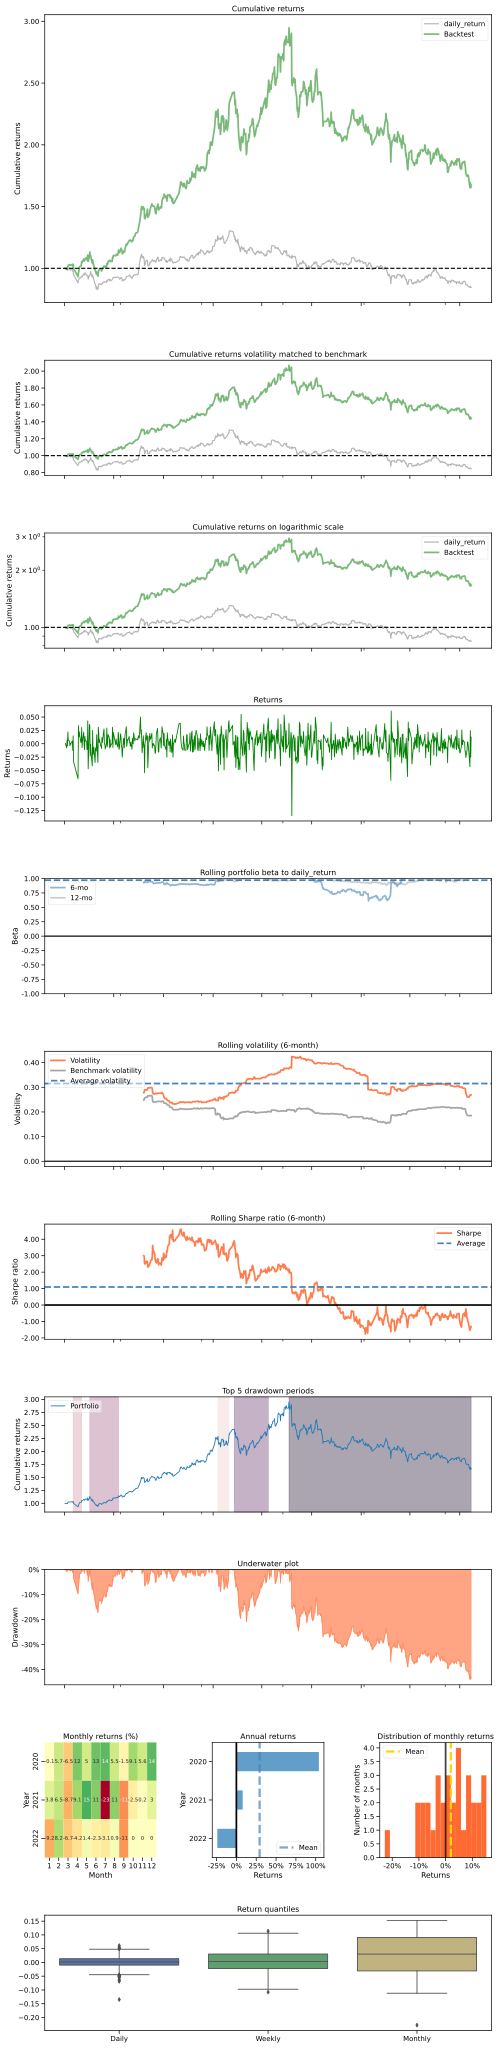

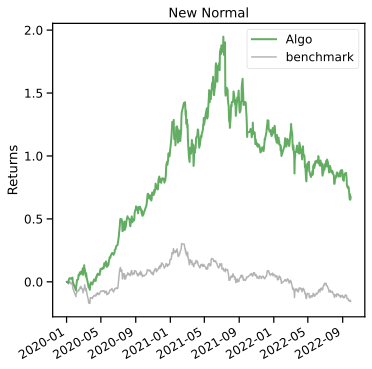

In [36]:
import pyfolio
from pyfolio import timeseries

%matplotlib inline

daily_return = get_daily_return(df_account_value)
daily_return_base = get_daily_return(baseline_df, value_col_name='close')

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = daily_return,
                                       benchmark_rets = daily_return_base, set_context=False)